In [1]:
# import all necessary packages & modules
import os
import time
import numpy as np
import pandas as pd
import json
import pyomo.environ as pyomo
from pyomo.opt import ProblemFormat
import matplotlib.pyplot as plt
import networkx as nx
import highspy
from networkx.readwrite import json_graph
from pyomo.opt import SolverStatus, TerminationCondition
from good_model_working import utils


import good_model_working
from good_model_working.reload import deep_reload
from good_model_working import opt_model
from good_model_working import diagnostics

In [2]:
deep_reload(good_model_working)

# Removing generators for testing
gen_to_remove = [
        #'Fossil Waste', 
        #'Municipal Solid Waste', 
        #'Non-Fossil Waste', 
        'Pumped Storage',
        'Fuel Cell',
        'Landfill Gas', 
        #"Energy Storage", 
        #"Solar PV", 
        #"Onshore Wind", 
        #'New Battery Storage', 
        #'IMPORT', 
        #'Tires',
        'Offshore Wind', 
        'Solar Thermal'
        ]


# import the model data & sets
input_sets = utils.get_sets('/Users/haniftayarani/good_model/Model Input/all_input_sets_sorted.json')
model_sets = utils.filter_sets(input_sets, gen_to_remove)

graph = utils.create_graph('/Users/haniftayarani/good_model/Model Input/all_input_objects.json')

In [3]:
deep_reload(good_model_working)

# MODEL TESTING
'''
    To analyze specific regions, input the appropriate subregion
    to the variable sub_region below
'''

user_input = input('Please select your region(s) for analysis (separated by commas): \nAll\nFlorida\nMISO\nNew England\nPJM\nSSP\nSoutheast\nERCOT\nWECC\n')

subgraph, sub_nodes = utils.get_subgraph(user_input, graph)

constraint_to_deactivate = ['generator', 'solar', 'wind', 'storage']

model_data = {
    'test_nodes': True,
    'test_cons': False,
    'graph': graph, 
    'sets': model_sets, 
    'subgraph_nodes': sub_nodes, 
    'subgraph': subgraph,
    'constraint_deactivation': None
}

In [4]:
# import good_model_working
deep_reload(good_model_working)

#Change this to point to your version of cbc or use another solver
solver_name='appsi_highs'

# run model 
problem = good_model_working.opt_model.Opt_Model(model_data, solver_name)

[+   6.64] Grid built
[+   0.00] Sets built
[+   0.40] Parameters built
[+   0.80] Variables built
[+   1.51] Objective Function built
[+   7.64] Local Constraints built
[+   0.56] Transmission constraints built
[+   0.00] Starting balanacing constraint...
[+  12.66] Balancing constraint built
[+   0.00] All Constraints built
[+   0.00] Model built


In [5]:
deep_reload(good_model_working.utils)

# Generate simple model statistics
utils.get_model_statistcs(problem.model)
utils.get_total_generator_count(problem.model)

 total_variables  total_constraints
          715672             730802
Total generators: 3794.0


In [6]:
# Solve the model
problem.solve_model()

# print the objective value
print(f"Total system cost: ${pyomo.value(problem.model.obj_func):,.2f}")

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
10661 rows, 682017 cols, 1081593 nonzeros
10661 rows, 443839 cols, 828413 nonzeros
10661 rows, 443839 cols, 828413 nonzeros
Presolve : Reductions: rows 10661(-720141); columns 443839(-271833); elements 828413(-1345398)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     4.4834950063e-02 Pr: 10135(1.8012e+10) 1s
      38098     1.6495529087e+09 Pr: 0(0); Du: 0(6.93889e-16) 3s
      38098     1.6495529087e+09 Pr: 0(0); Du: 0(6.93889e-16) 3s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
      38098     1.6495557796e+09 Pr: 1017(0.00036528); Du: 0(2.99501e-05) 4s
      38098     1.6495557796e+09 4s
Model   status      : Optimal
Simplex   iterations: 38098
Objective value    

In [7]:
deep_reload(good_model_working)

# Get model results
results = problem.get_results()

In [8]:
# get diagnostics
deep_reload(diagnostics)

hourly_mix = diagnostics.get_hourly_gen_mix(results)
annual_mix = diagnostics.get_annual_gen_mix(results)

In [9]:
# Compare 2021 US annual mix baseline to model generated fuel mix
deep_reload(diagnostics)

diagnostics.compare_annual_mix_to_baseline(annual_mix)

                        Resource Percentage_Baseline Percentage_Model
0                           Coal             21.900%          14.738%
1                            Oil              0.600%           4.618%
2                            Gas             38.400%          33.874%
3                   Other Fossil              0.500%           0.000%
4                        Nuclear             18.900%          21.265%
5                          Hydro              6.000%           1.276%
6                        Biomass              1.300%           0.885%
7                           Wind              9.200%          16.440%
8                          Solar              2.800%           6.127%
9                     Geothermal              0.400%           0.776%
10  Other unknown/purchased fuel              0.100%           0.000%


/Users/haniftayarani/good_model/toy_src/good_model_working/diagnostics.py:124: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  hourly_df = hourly_df.groupby(level=0, axis=1).sum()


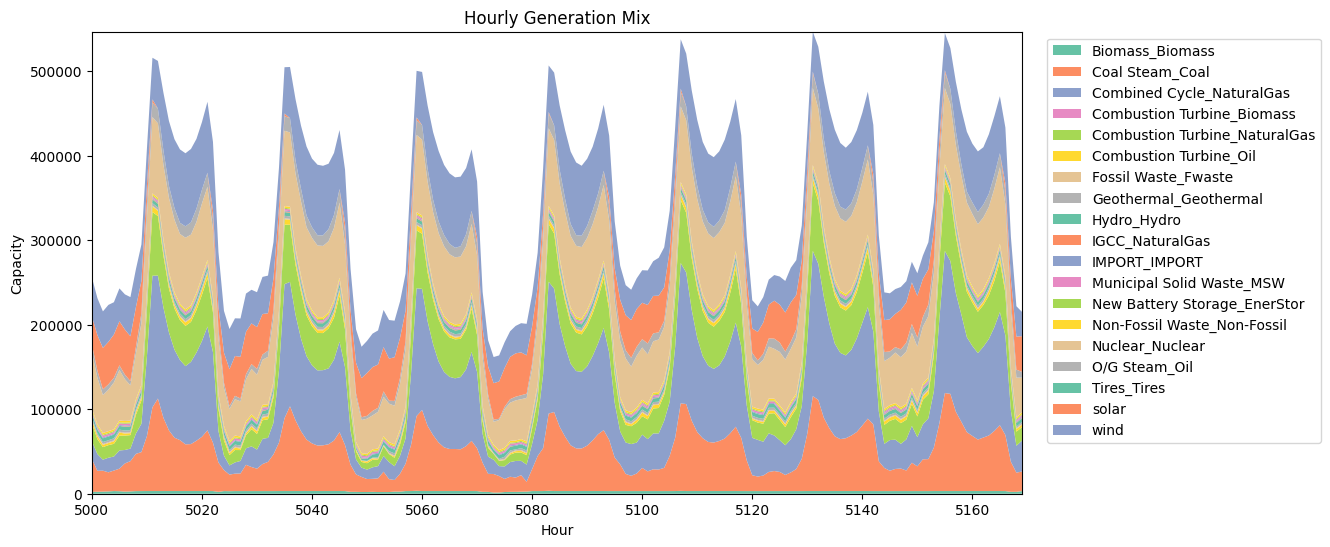

In [10]:
# plot diagnostics
deep_reload(diagnostics)

diagnostics.plot_hourly_gen_mix(hourly_mix)

In [11]:
import pickle

# Specify the path to save the pickle file
pickle_file_path = 'results.pickle'

# Save the dictionary as a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(results, f)
    
nodes_dict = results.get('nodes', {})